#### Part1 파이토치와 신경망 기초
---
Chapter 1. 파이토치 기본

In [1]:
import torch

In [ ]:
# normal python variables
x = 3.5
y = x*x + 2
print(x,y)

3.5 14.25


In [ ]:
# simple pytorch tensor
x = torch.tensor(3.5)
print(x)

tensor(3.5000)


In [ ]:
# simple arithmetic with tensors
y = x + 3
print(y)

tensor(6.5000)


In [ ]:
# pytorch tensor with gradient enabled
x = torch.tensor(3.5, requires_grad=True)
print(x)

tensor(3.5000, requires_grad=True)


In [ ]:
# y is defined as a fucnction of x
y = (x-1) * (x-2) * (x-3)
print(y)

tensor(1.8750, grad_fn=<MulBackward0>)


In [ ]:
# work out gradients
y.backward()

In [ ]:
# what is gradient at x = 3.5
x.grad

tensor(5.7500)

In [ ]:
# set up simple graph relating x, y and z
x = torch.tensor(3.5, requires_grad=True)
y = x * x
z = 2 * y + 3

In [ ]:
# work out gradients
z.backward()

In [ ]:
# what is gradient at x = 3.5
print(x.grad)

tensor(14.)


In [ ]:
# set up simple graph relating x, y and z
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

x = 2 * a + 3 * b
y = 5 * a * a + 3 * b * b * b
z = 2 * x + 3 * y

In [ ]:
# work out gradients
z.backward()

In [ ]:
# what is gradient at a = 2.0
a.grad

tensor(64.)

---
Chapter 2. 파이토치로 만드는 첫 번째 신경망

In [2]:
# mount Drive to access data fiels

from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [3]:
# csv 파일을 읽기 위해 pandas 임포트
import pandas

In [4]:
df = pandas.read_csv('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,147,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 359.3 MB


In [6]:
# 이미지를 확인하기 위해 matplotlib 임포트
import matplotlib.pyplot as plt

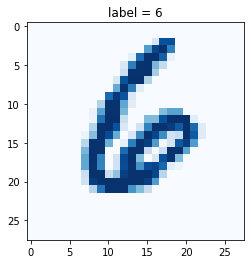

In [ ]:
# get data from dataframe
row = 13
data = df.iloc[row]

# label is the first value
label = data[0]

# image data is the remaining 784 values
img = data[1:].values.reshape(28,28)
plt.title("label = " + str(label))
plt.imshow(img, interpolation='none', cmap='Blues')
plt.show()

In [7]:
# library import
import torch
import torch.nn as nn

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    # 부모 클래스 초기화
    super().__init__()
    
    # 신경망 레이어 정의
    self.model = nn.Sequential(
      nn.Linear(784,200),
      nn.Sigmoid(),
      nn.Linear(200, 10),
      nn.Sigmoid()
    )
    
    # 손실함수 설정
    self.loss_function = nn.MSELoss()
    
    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

    self.counter = 0
    self.progress = []
    
    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)
  
  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    #손실 계산
    loss = self.loss_function(outputs, targets)

    self.counter += 1
    if (self.counter % 10 == 0) :
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0) :
      print("counter = ", self.counter)
      pass

    #기울기 초기화, 역전파 실행, 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.',
            grid=True, yticks=(0, 0.25, 0.5))
    pass
  
  pass

In [8]:
from torch.utils.data import Dataset

In [9]:
class MnistDataset(Dataset):
  
  def __init__(self, csv_file):
    self.data_df = pandas.read_csv(csv_file, header=None)
    pass
  
  def __len__(self):
    return len(slef.data_df)

  def __getitem__(self, index):
    # 이미지 목표(레이블)
    label = self.data_df.iloc[index, 0]
    target = torch.zeros((10))
    target[label] = 1.0

    # 0-255의 이미지를 0-1로 정규화
    image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values) / 255.0

    # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
    return label, image_values, target
  
  def plot_image(self, index):
    img = self.data_df.iloc[index, 1:].values.reshape(28,28)
    plt.title("label = " + str(self.data_df.iloc[index, 0]))
    plt.imshow(img, interpolation='none', cmap='Blues')
    pass
  
  pass

In [10]:
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv')

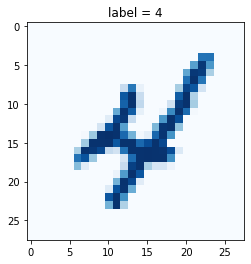

In [11]:
mnist_dataset.plot_image(9)

In [ ]:
%%time

# 신경망 생성
C = Classifier()

# MNIST 데이터에 대해 훈련 진행
epochs = 3

for i in range(epochs):
  print('training epoch', i+1, "of", epochs)
  for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)
    pass
  pass

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 3min 12s, sys: 1.84 s, total: 3min 14s
Wall time: 3min 14s


In [ ]:
C.plot_progress()

In [19]:
# MNIST 테스트 데이터 로드
mnist_test_dataset=MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_test.csv')

In [16]:
# 레코드 설정
record = 19

In [ ]:
# 이미지와 정답 출력
mnist_test_dataset.plot_image(record)

---
Chapter 3. 성능 향상 기법

In [12]:
class Classifier(nn.Module):
  def __init__(self):
    # 부모 클래스 초기화
    super().__init__()
    
    # 신경망 레이어 정의
    self.model = nn.Sequential(
      nn.Linear(784,200),
      nn.Sigmoid(),
      nn.Linear(200, 10),
      nn.Sigmoid()
    )
    
    # 손실함수 설정
    self.loss_function = nn.BCELoss()
    
    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

    self.counter = 0
    self.progress = []
    
    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)
  
  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    #손실 계산
    loss = self.loss_function(outputs, targets)

    self.counter += 1
    if (self.counter % 10 == 0) :
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0) :
      print("counter = ", self.counter)
      pass

    #기울기 초기화, 역전파 실행, 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.',
            grid=True, yticks=(0, 0.25, 0.5))
    pass
  
  pass

In [13]:
%%time

# 신경망 생성
C = Classifier()

# MNIST 데이터에 대해 훈련 진행
epochs = 3

for i in range(epochs):
  print('training epoch', i+1, "of", epochs)
  for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)
    pass
  pass

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 3min 56s, sys: 2.35 s, total: 3min 59s
Wall time: 3min 59s


In [21]:
# visualise the answer by the neural network
image_data = mnist_test_dataset[record][1]

In [22]:
# query from trained network
output = C.forward(image_data)

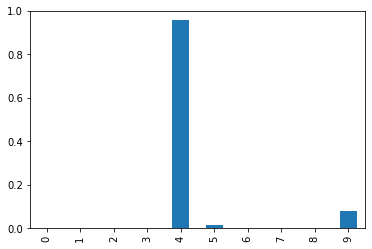

In [23]:
# plot output tensor
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

In [24]:
# test trained neural network on training data

score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor).detach().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1
    
    pass

print(score, items, score/items)

9028 10000 0.9028


In [28]:
class Classifier(nn.Module):
  def __init__(self):
    # 부모 클래스 초기화
    super().__init__()
    
    # 신경망 레이어 정의
    self.model = nn.Sequential(
      nn.Linear(784,200),
      nn.LeakyReLU(0.02),
      
      nn.LayerNorm(200),
      
      nn.Linear(200, 10),
      nn.Sigmoid()
    )
    
    # 손실함수 설정
    self.loss_function = nn.BCELoss()
    
    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

    self.counter = 0
    self.progress = []
    
    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)
  
  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    #손실 계산
    loss = self.loss_function(outputs, targets)

    self.counter += 1
    if (self.counter % 10 == 0) :
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0) :
      print("counter = ", self.counter)
      pass

    #기울기 초기화, 역전파 실행, 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.',
            grid=True, yticks=(0, 0.25, 0.5))
    pass
  
  pass

In [29]:
%%time

# 신경망 생성
C = Classifier()

# MNIST 데이터에 대해 훈련 진행
epochs = 3

for i in range(epochs):
  print('training epoch', i+1, "of", epochs)
  for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)
    pass
  pass

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 4min 16s, sys: 3.04 s, total: 4min 19s
Wall time: 4min 18s


In [30]:
# visualise the answer by the neural network
image_data = mnist_test_dataset[record][1]

In [31]:
# query from trained network
output = C.forward(image_data)

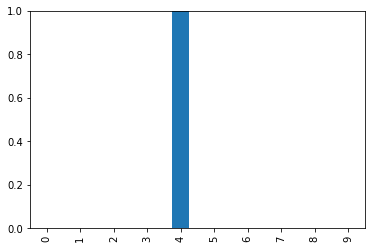

In [32]:
# plot output tensor
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

In [33]:
# test trained neural network on training data

score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor).detach().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1
    
    pass

print(score, items, score/items)

9733 10000 0.9733
